## Example usage of PhaseNetWC-J (PhaseNet wide-channel variant trained on JMA data)

last update on 2025.11.01

In [1]:
# required packages
# pip install seisbench
# pip install torchinfo

### Verified environment (2025-11-01)
- Environment: Python 3.13.1
- `seisbench==0.10.2`
- `torchinfo==1.8.0`

### Imports

In [2]:
import torch
import numpy as np
import seisbench.models as sbm
import h5py
import matplotlib.pyplot as plt
from torchinfo import summary

/Users/naoi/Dropbox/00_work/_Github/JMAuniPicker/venv_test/lib/python3.13/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Helper to widen channels with PyTorch

In [3]:
def double_channels(model):
    import torch.nn as nn   
    model.inc = nn.Conv1d(3, 16, kernel_size=7, stride=1, padding='same')
    model.in_bn = nn.BatchNorm1d(16, eps=1e-3)
    
    model.down_branch[0][0] = nn.Conv1d(16, 16, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[0][1] = nn.BatchNorm1d(16, eps=1e-3)
    model.down_branch[0][2] = nn.Conv1d(16, 16, kernel_size=7, stride=4, padding=3, bias=False)  
    model.down_branch[0][3] = nn.BatchNorm1d(16, eps=1e-3)
    
    model.down_branch[1][0] = nn.Conv1d(16, 32, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[1][1] = nn.BatchNorm1d(32, eps=1e-3)
    model.down_branch[1][2] = nn.Conv1d(32, 32, kernel_size=7, stride=4, padding=0, bias=False)  
    model.down_branch[1][3] = nn.BatchNorm1d(32, eps=1e-3)
    
    model.down_branch[2][0] = nn.Conv1d(32, 64, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[2][1] = nn.BatchNorm1d(64, eps=1e-3)
    model.down_branch[2][2] = nn.Conv1d(64, 64, kernel_size=7, stride=4, padding=0, bias=False)  
    model.down_branch[2][3] = nn.BatchNorm1d(64, eps=1e-3)
    
    model.down_branch[3][0] = nn.Conv1d(64, 128, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[3][1] = nn.BatchNorm1d(128, eps=1e-3)
    model.down_branch[3][2] = nn.Conv1d(128, 128, kernel_size=7, stride=4, padding=0, bias=False)  
    model.down_branch[3][3] = nn.BatchNorm1d(128, eps=1e-3)
    
    model.down_branch[4][0] = nn.Conv1d(128, 256, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[4][1] = nn.BatchNorm1d(256, eps=1e-3)
    
    model.up_branch[0][0] = nn.ConvTranspose1d(256, 128, 7, 4, bias=False)
    model.up_branch[0][1] = nn.BatchNorm1d(128, eps=1e-3)
    model.up_branch[0][2] = nn.Conv1d(256, 128, 7, stride=1,padding="same", bias=False)
    model.up_branch[0][3] = nn.BatchNorm1d(128, eps=1e-3)

    model.up_branch[1][0] = nn.ConvTranspose1d(128, 64, 7, 4, bias=False)
    model.up_branch[1][1] = nn.BatchNorm1d(64, eps=1e-3)
    model.up_branch[1][2] = nn.Conv1d(128, 64, 7, stride=1,padding="same", bias=False)
    model.up_branch[1][3] = nn.BatchNorm1d(64, eps=1e-3)

    model.up_branch[2][0] = nn.ConvTranspose1d(64, 32, 7, 4, bias=False)
    model.up_branch[2][1] = nn.BatchNorm1d(32, eps=1e-3)
    model.up_branch[2][2] = nn.Conv1d(64, 32, 7, stride=1,padding="same", bias=False)
    model.up_branch[2][3] = nn.BatchNorm1d(32, eps=1e-3)

    model.up_branch[3][0] = nn.ConvTranspose1d(32, 16, 7, 4, bias=False)
    model.up_branch[3][1] = nn.BatchNorm1d(16, eps=1e-3)
    model.up_branch[3][2] = nn.Conv1d(32, 16, 7, stride=1,padding="same", bias=False)
    model.up_branch[3][3] = nn.BatchNorm1d(16, eps=1e-3)

    model.out = nn.Conv1d(16, 3, kernel_size=1, stride=1, padding='same')
    
    return model

### Read sample data

In [4]:
# load data (MATLAB v7.3 matfile = HDF5 file)
filename = 'data/sample_wv.mat'
with h5py.File(filename, 'r') as file:
    wv = file['wv'][()]
wv = wv.transpose(2, 1, 0).astype(np.float32)

# standardization
mean = np.mean(wv, axis=2, keepdims=True)
std = np.std(wv, axis=2, keepdims=True)
wv = (wv - mean) / std

wv_tensor = torch.from_numpy(wv)

### Load PhaseNetWC models and weights

In [5]:
weights_path = "models01/model_PhaseNetWC_JMA.pth"
state_dict_wc = torch.load(weights_path, map_location="cpu")

# Method 1: Widen channels manually and load local .pth weights
model01 = sbm.PhaseNet(phases="PSN", norm="std")
model01 = double_channels(model01)
model01.load_state_dict(state_dict_wc)

# Method 2: Use filter_factor helper (should match manual edits)
model02 = sbm.PhaseNet(phases="PSN", norm="std", filter_factor=2)
model02.load_state_dict(state_dict_wc)

# Method 3: Load SeisBench-distributed pretrained weights
model03 = sbm.PhaseNet.from_pretrained("jma_wc")

summary(model01)

Layer (type:depth-idx)                   Param #
PhaseNet                                 --
├─Conv1d: 1-1                            352
├─BatchNorm1d: 1-2                       32
├─ModuleList: 1-3                        --
│    └─ModuleList: 2-1                   --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             32
│    │    └─Conv1d: 3-3                  1,792
│    │    └─BatchNorm1d: 3-4             32
│    └─ModuleList: 2-2                   --
│    │    └─Conv1d: 3-5                  3,584
│    │    └─BatchNorm1d: 3-6             64
│    │    └─Conv1d: 3-7                  7,168
│    │    └─BatchNorm1d: 3-8             64
│    └─ModuleList: 2-3                   --
│    │    └─Conv1d: 3-9                  14,336
│    │    └─BatchNorm1d: 3-10            128
│    │    └─Conv1d: 3-11                 28,672
│    │    └─BatchNorm1d: 3-12            128
│    └─ModuleList: 2-4                   --
│    │    └─Conv1d: 3-13                 57,344


## Prediction

Run the cells below to compute PyTorch predictions.

In [6]:
# apply models
model01.eval()
with torch.no_grad():
    pred01 = model01(wv_tensor).detach().numpy()
    
model02.eval()
with torch.no_grad():
    pred02 = model02(wv_tensor).detach().numpy()
    
model03.eval()
with torch.no_grad():
    pred03 = model03(wv_tensor).detach().numpy()

In [7]:
# confirm outputs match
max_diff_01and02 = np.max(np.abs(pred01 - pred02))
max_diff_01and03 = np.max(np.abs(pred01 - pred03))

print(f"01 vs 02 max |Δ| = {max_diff_01and02:.3e}")
print(f"01 vs 03 max |Δ| = {max_diff_01and03:.3e}")


01 vs 02 max |Δ| = 0.000e+00
01 vs 03 max |Δ| = 0.000e+00


### Plot prediction result (PyTorch models)

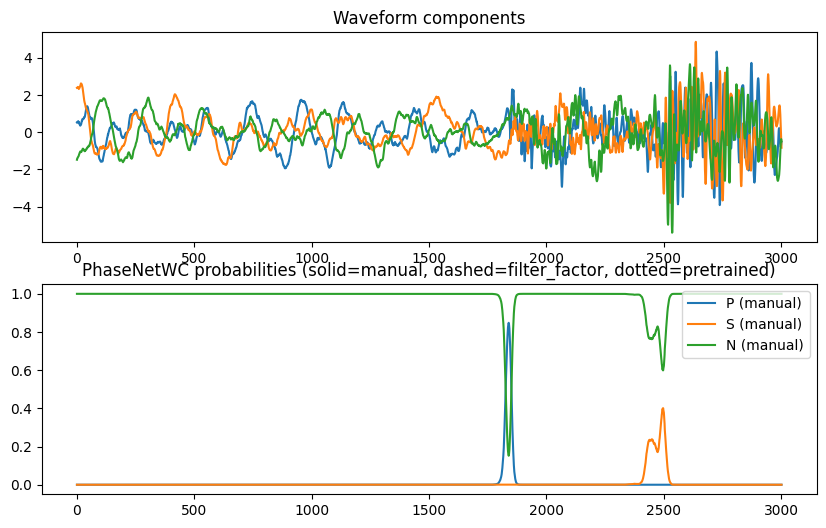

In [8]:
# plot results
wvno = 1
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(wv[wvno, :, :].T)
axes[0].set_title("Waveform components")
axes[1].plot(pred01[wvno, :, :].T)
axes[1].set_title("PhaseNetWC probabilities (solid=manual, dashed=filter_factor, dotted=pretrained)")
axes[1].legend(["P (manual)", "S (manual)", "N (manual)", "P (ff2)", "S (ff2)", "N (ff2)", "P (pretrained)", "S (pretrained)", "N (pretrained)"], loc="upper right")